In [10]:
import os
import csv 
import sys 
import numpy as np
from scipy import sparse
from collections import Counter

try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET


from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

import util

In [2]:
def write_to_file(rows, outfile):
    """
    assumes len(predictions) == len(ids), and that predictions[i] is the
    index of the predicted class with the malware_classes list above for 
    the executable corresponding to ids[i].
    outfile will be overwritten
    """
    with open(outfile,"w+") as f:
        for r in rows:
            f.write("%s\n" % (r))

In [3]:
def reorder_submission(file_to_reorder, newfile_name = "experiment_results.csv"):
    # READ IN KEYS IN CORRECT ORDER AS LIST
    with open('keys.csv','r') as f:
        keyreader = csv.reader(f)
        keys = [key[0] for key in keyreader]

    # READ IN ALL PREDICTIONS, REGARDLESS OF ORDER
    with open(file_to_reorder) as f:
        oldfile_reader = csv.reader(f)
        D = {}
        for i,row in enumerate(oldfile_reader):
            if i == 0:
                continue
            _id, pred = row 
            D[_id] = pred

    # WRITE PREDICTIONS IN NEW ORDER
    with open(newfile_name,'w') as f:
        writer = csv.writer(f)
        writer.writerow(('Id','Prediction'))
        for key in keys:
            writer.writerow((key,D[key]))

    print("".join(["Reordered ", file_to_reorder," and wrote to ", newfile_name]))

In [4]:
from keras.layers import Dense # For dense layers
from keras.models import Sequential # For sequential layering
from keras.callbacks import EarlyStopping # For stopping execution
from sklearn.metrics import accuracy_score

def train_model_DL(X_train, Y_train, n_nodes, n_output = 1, hid_activation = 'sigmoid', out_activation = 'softmax', optimizer = 'adam', loss = 'categorical_crossentropy'):
    """ n_nodes is 1-D numpy array with number of nodes on each layer
        e.g. [10,20,30] is a model with 3 (hidden) layers,
        with 10/20/30 nodes on the first/second/third layers
        Returns trained DL model """
    input_shape = (X_train.shape[1],) # Shape of input data
    # Initialize model
    model_DL = Sequential()
    for i in range(len(n_nodes)):
        if i == 0:
            # First layer
            model_DL.add(Dense(n_nodes[i], activation = hid_activation, input_shape = input_shape))
        else:
            # Subsequent layers
            model_DL.add(Dense(n_nodes[i],activation = hid_activation))
    # Output layer
    model_DL.add(Dense(n_output, activation = out_activation))
    # Compile model
    model_DL.compile(optimizer = optimizer,loss = loss, metrics=['accuracy'])
    # Print model summary
    model_DL.summary()
    # Early stopping monitor w/ patience=3 (stop after 3 runs without improvements)
    early_stopping_monitor = EarlyStopping(patience=10)
    # Fit model using 20% of data for validation
    model_DL.fit(X_train, Y_train, validation_split=0.2, epochs=200, callbacks=[early_stopping_monitor])
    return model_DL

Using TensorFlow backend.


In [5]:
def get_classes_ids(direc):
    classes = []
    ids = [] 
    for datafile in os.listdir(direc):
        # extract id and true class (if available) from filename
        id_str,clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.origin_malware_classes.index(clazz))
        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)
    return np.array(classes), ids

In [6]:
def get_file_feature(direc):
    filesizes = []
    process_size = []
    thread_size = []
    for datafile in os.listdir(direc):
        filesizes = np.append(filesizes, os.path.getsize(os.path.join(direc,datafile))/1000)
        tree = ET.parse(os.path.join(direc,datafile))
        n_process = 0
        n_thread = 0
        for el in tree.iter():
            if el.tag == "process":
                n_process += 1
            elif el.tag == "thread":
                n_thread += 1
        process_size.append(n_process)
        thread_size.append(n_thread)
        
    filesizes = np.array(filesizes)
    filesizes = np.true_divide(filesizes, np.std(filesizes))
    process_size = np.array(process_size)
    process_size = np.true_divide(process_size, np.std(process_size))
    thread_size = np.array(thread_size)
    thread_size = np.true_divide(thread_size, np.std(thread_size))

    return np.asmatrix(np.array((filesizes, process_size, thread_size))).T

In [7]:
#############################
#
#  Below is main function
#
#############################

In [8]:
train_dir = "../train_origin"
test_dir = "../test_origin"

In [11]:
train_classes, _ = get_classes_ids(train_dir)

In [12]:
_, ids = get_classes_ids(test_dir)

In [26]:
y_train = np.zeros((len(train_classes),len(util.malware_classes)))
y_train[np.arange(len(train_classes)), train_classes] = 1
y_train.shape

(3086, 15)

In [27]:
X_train = sparse.load_npz("tfidf_train_tokens.npz")
X_test = sparse.load_npz("tfidf_test_tokens.npz")

In [28]:
train_features = get_file_feature(train_dir)
test_features = get_file_feature(test_dir)
print train_features.shape
print test_features.shape

(3086, 3)
(3724, 3)


In [29]:
X_train = sparse.hstack([X_train, train_features])
X_test = sparse.hstack([X_test, test_features])

In [30]:
print X_train.shape
print X_test.shape

(3086, 159892)
(3724, 159892)


In [31]:
########################
#
# Finish collecting data
#
########################

In [71]:
X_train = X_train_bkup
X_test = X_test_bkup

In [72]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 1000, n_jobs = -1, class_weight="balanced")
RF.fit(X_train, y_train)
scores = cross_val_score(RF, X_train, y_train, cv=5)
print "Features: " + str(RF.n_features_) + ("\tAccuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))
RF_best = RF
score_best = scores.mean()
X_train_best = X_train
X_test_best = X_test

Features: 159892	Accuracy: 0.85710 (+/- 0.02777)


In [73]:
#X_train_bkup = X_train
#X_test_bkup = X_test

In [74]:
from sklearn.feature_selection import SelectFromModel
while X_train.shape[1] > 100000:
    model = SelectFromModel(RF, prefit=True, threshold = "0.2*mean")
    X_train = model.transform(X_train)
    ## trick: break if we didn't remove any feature
    if X_train.shape[1] == X_test.shape[1]:
        break
    X_test = model.transform(X_test)
    
    RF = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
    RF.fit(X_train, y_train)
    scores = cross_val_score(RF, X_train, y_train, cv=5)
    mean_score = scores.mean()
    print "Features: " + str(RF.n_features_) + ("\tAccuracy: %0.5f (+/- %0.5f)" % (mean_score, scores.std() * 2))
    
    if score_best <= mean_score:
        del X_train_best
        del X_test_best
        RF_best = RF
        score_best = mean_score
        X_train_best = X_train
        X_test_best = X_test

Features: 23672	Accuracy: 0.86228 (+/- 0.02817)


In [75]:
X_train4_all = X_train_best
X_test4 = X_test_best

In [76]:
# Initialize array of results
results4 = np.full(X_test4.shape[0],-1)
classes = np.array(util.origin_malware_classes)
n_classes = len(classes)
iclasses = np.arange(n_classes)
ih = np.arange(X_test4.shape[0])
for i in range(n_classes-1):
    # Fit classifier on current classes
    RF_vec4_ = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                      n_estimators=1000, max_features='sqrt')
    y_train_ = y_train[:,iclasses]
    ix = np.sum(y_train_,axis=1) > 0
    RF_vec4_.fit(X_train4_all[ix,:], y_train_[ix,:])
    print(i+1,') Scores: Train ', cross_val_score(RF_vec4_, X_train4_all[ix,:], y_train_[ix,:], cv = 5))
    # Find smallest class with largest score  
    scores = []
    for j in iclasses:
        score = cross_val_score(RF_vec4_, X_train4_all[ix, :],
                            y_train[ix,j], cv = 5)
        print "\t\tscore for class " + util.origin_malware_classes[j] + ": " + str(score.mean())
        scores.append(score.mean())
    scores = np.array(scores)
    imax = [np.argmax(scores)]
    if len(imax) > 1:
        y_train_ = y_train[:,iclasses[imax]]
        imax = imax[np.argmin(np.sum(y_train_,axis=0))]
    else: imax = imax[0]
    print('     Best class: {:10s} ({:3d} elements). Score: {:.3f}'.format(classes[imax],
        int(np.sum(y_train[:,iclasses[imax]],axis=0)), scores[imax]))
    # Make predictions for best class
    preds4_ = RF_vec4_.predict(X_test4[ih,:])
    results4_ = np.argmax(preds4_, axis=1)
    if i < n_classes-2:
        results4[ih[results4_ == imax]] = iclasses[imax]
        # Take out best class
        ih = ih[results4_ != imax]
        classes = np.delete(classes, imax)
        iclasses = np.delete(iclasses, imax)
    else:
        results4[ih] = iclasses[results4_]

(1, ') Scores: Train ', array([0.8592233 , 0.83468395, 0.85737439, 0.86385737, 0.87844408]))
		score for class Agent: 0.9676018480163968
		score for class AutoRun: 0.9912516456599162
		score for class FraudLoad: 0.9931954827703912
		score for class FraudPack: 0.9974078527515925
		score for class Hupigon: 0.9919004683902168
		score for class Krap: 0.9935185845557044
		score for class Lipler: 0.9990270247551802
		score for class Magania: 0.9970831825358111
		score for class None: 0.9306582500021626
		score for class Poison: 0.9931944422589731
		score for class Swizzor: 0.9974057546991096
		score for class Tdss: 0.9938453613387918
		score for class VB: 0.9766675583389718
		score for class Virut: 0.9808835760705126
		score for class Zbot: 0.9957881596408132
     Best class: Lipler     ( 53 elements). Score: 0.999
(2, ') Scores: Train ', array([0.8616145 , 0.83855025, 0.8583196 , 0.86138614, 0.87458746]))
		score for class Agent: 0.9670336433074189
		score for class AutoRun: 0.9917567868813

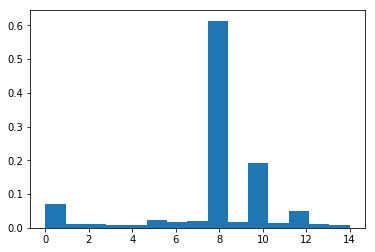

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(results4,bins=15, normed = True)
plt.show()

In [78]:
util.write_predictions(results4, ids, "tdidf_seq_rf.csv")
reorder_submission("tdidf_seq_rf.csv", "all_seleted_seq_rf_results_final.csv")

Reordered tdidf_seq_rf.csv and wrote to all_seleted_seq_rf_results_final.csv


In [79]:
X_train4_all = X_train_best
X_test4 = X_test_best

In [80]:
# Initialize array of results
prop = [3.69, 1.62, 1.20, 1.03, 1.33, 1.26, 1.72, 1.33, 52.14, 0.68, 17.56, 1.04, 12.18, 1.91, 1.30]
results4 = np.full(X_test4.shape[0],-1)
classes = np.array(util.origin_malware_classes)
n_classes = len(classes)
iclasses = np.arange(n_classes)
ih = np.arange(X_test4.shape[0])
for i in range(n_classes-1):
    # Fit classifier on current classes
    RF_vec4_ = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                      n_estimators=1000, max_features='sqrt')
    y_train_ = y_train[:,iclasses]
    imax = np.argmax(prop)
    if len(imax) > 1:
        imax = imax[0]
    prop[imax] = -1
    
    ix = np.sum(y_train_,axis=1) > 0
    
    RF_vec4_.fit(X_train4_all[ix,:], y_train[ix,imax])
    print(i+1,') Scores: Train ', cross_val_score(RF_vec4_, X_train4_all[ix,:], y_train_[ix,imax], cv = 5))
    # Find smallest class with largest score  
    
    print('     Best class: {:10s} ({:3d} elements)'.format(classes[imax],
        int(np.sum(y_train[:,iclasses[imax]],axis=0))))
    # Make predictions for best class
    preds4_ = RF_vec4_.predict(X_test4[ih,:])
    results4_ = np.argmax(preds4_, axis=1)
    if i < n_classes-2:
        results4[ih[results4_ == imax]] = iclasses[imax]
        # Take out best class
        ih = ih[results4_ != imax]
        classes = np.delete(classes, imax)
        iclasses = np.delete(iclasses, imax)
    else:
        results4[ih] = iclasses[results4_]

TypeError: object of type 'numpy.int64' has no len()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(results4,bins=15, normed = True)
plt.show()

In [ ]:
util.write_predictions(results4, ids, "tdidf_seq_rf.csv")
reorder_submission("tdidf_seq_rf.csv", "all_seleted_seq_rf_results_final2.csv")

In [34]:
sparse.save_npz("tfidf_train_major_features.npz", X_train_major_best)
sparse.save_npz("tfidf_test_major_features.npz", X_test_major_best)

In [35]:
# X_train_major_best = sparse.load_npz("tfidf_train_major_features.npz")
# X_test_major_best = sparse.load_npz("tfidf_test_major_features.npz")

In [36]:
from sklearn.ensemble import RandomForestClassifier
RF_major = RandomForestClassifier(n_estimators = 100, n_jobs = -1, max_features = None)
RF_major.fit(X_train_major_best, y_train_major)
scores = cross_val_score(RF_major, X_train_major_best, y_train_major, cv=5)
print "Features: " + str(RF_major.n_features_) + ("\tAccuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

Features: 131	Accuracy: 0.89987 (+/- 0.03900)


In [37]:
preds_RF_major = RF_major.predict(X_test_major_best)
results_RF_major = np.argmax(preds_RF_major, axis=1)
print results_RF_major

[1 0 0 ..., 3 0 0]


In [38]:
model_DL_major = train_model_DL(X_train_major_best,y_train_major,[100], 4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               13200     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 13,604
Trainable params: 13,604
Non-trainable params: 0
_________________________________________________________________
Train on 2468 samples, validate on 618 samples
Epoch 1/200
2468/2468 [==============================] - 0s 144us/step - loss: 1.2445 - acc: 0.4562 - val_loss: 1.0526 - val_acc: 0.5680
Epoch 2/200
2468/2468 [==============================] - 0s 96us/step - loss: 1.0712 - acc: 0.5446 - val_loss: 0.9624 - val_acc: 0.6230
Epoch 3/200
2468/2468 [==============================] - 0s 96us/step - loss: 0.9858 - acc: 0.5794 - val_loss: 0.8887 - val_acc: 0.6731
Epoch 4/200
2468/2468 [==============================] - 0s 96us/step - loss: 

2468/2468 [==============================] - 0s 95us/step - loss: 0.3517 - acc: 0.8626 - val_loss: 0.3480 - val_acc: 0.8722
Epoch 57/200
2468/2468 [==============================] - 0s 96us/step - loss: 0.3537 - acc: 0.8622 - val_loss: 0.3480 - val_acc: 0.8754
Epoch 58/200
2468/2468 [==============================] - 0s 96us/step - loss: 0.3500 - acc: 0.8667 - val_loss: 0.3482 - val_acc: 0.8657
Epoch 59/200
2468/2468 [==============================] - 0s 96us/step - loss: 0.3475 - acc: 0.8639 - val_loss: 0.3475 - val_acc: 0.8576
Epoch 60/200
2468/2468 [==============================] - 0s 97us/step - loss: 0.3456 - acc: 0.8626 - val_loss: 0.3420 - val_acc: 0.8786
Epoch 61/200
2468/2468 [==============================] - 0s 97us/step - loss: 0.3472 - acc: 0.8699 - val_loss: 0.3426 - val_acc: 0.8770
Epoch 62/200
2468/2468 [==============================] - 0s 94us/step - loss: 0.3439 - acc: 0.8635 - val_loss: 0.3422 - val_acc: 0.8706
Epoch 63/200
2468/2468 [==============================

Epoch 116/200
2468/2468 [==============================] - 0s 104us/step - loss: 0.2981 - acc: 0.8805 - val_loss: 0.3061 - val_acc: 0.8819
Epoch 117/200
2468/2468 [==============================] - 0s 111us/step - loss: 0.2958 - acc: 0.8853 - val_loss: 0.3001 - val_acc: 0.8916
Epoch 118/200
2468/2468 [==============================] - 0s 106us/step - loss: 0.2966 - acc: 0.8821 - val_loss: 0.2989 - val_acc: 0.8916
Epoch 119/200
2468/2468 [==============================] - 0s 101us/step - loss: 0.2964 - acc: 0.8797 - val_loss: 0.3001 - val_acc: 0.8803
Epoch 120/200
2468/2468 [==============================] - 0s 107us/step - loss: 0.2952 - acc: 0.8817 - val_loss: 0.3033 - val_acc: 0.8851
Epoch 121/200
2468/2468 [==============================] - 0s 97us/step - loss: 0.2939 - acc: 0.8825 - val_loss: 0.3006 - val_acc: 0.8916
Epoch 122/200
2468/2468 [==============================] - 0s 96us/step - loss: 0.2936 - acc: 0.8829 - val_loss: 0.2958 - val_acc: 0.8803
Epoch 123/200
2468/2468 [====

In [39]:
Y_train_DLpred = model_DL_major.predict(X_train_major_best)
results_train = np.argmax(Y_train_DLpred, axis=1)
acc_DL = accuracy_score(np.argmax(y_train_major, axis=1), results_train)
print('DONE. Accuracy: preds_DL_major = model_DL_m', acc_DL)

('DONE. Accuracy: preds_DL_major = model_DL_m', 0.89630589760207391)


In [40]:
preds_DL_major = model_DL_major.predict(X_test_major_best)
results_DL_major = np.argmax(preds_DL_major, axis=1)
print results_DL_major

[1 0 0 ..., 3 0 3]


In [41]:
#### second step ####

In [42]:
print y_train_minor.shape

(3086, 12)


In [43]:
y_train_minor_bkup = y_train_minor

In [44]:
# remove 0 rows (None, Swizzor, VB)
ix = np.sum(y_train_minor, axis=1) > 0

X_train_minor = X_train.tocsr()[ix, :]
y_train_minor = y_train_minor[ix, :]
X_test_minor = X_test

In [45]:
print X_train_minor.shape
print y_train_minor.shape
print X_test_minor.shape

(559, 159892)
(559, 12)
(3724, 159892)


In [46]:
RF = RandomForestClassifier(n_estimators = 100, n_jobs = -1, max_features = None)
RF.fit(X_train_minor, y_train_minor)
scores = cross_val_score(RF, X_train_minor, y_train_minor, cv=5)
print "Features: " + str(RF.n_features_) + ("\tAccuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))
RF_best = RF
score_best = scores.mean()
X_train_minor_best = X_train_minor
X_test_minor_best = X_test

Features: 159892	Accuracy: 0.66366 (+/- 0.02799)


In [47]:
while X_train_minor.shape[1] > 100:
    model = SelectFromModel(RF, prefit=True, threshold = "0.5*mean")
    X_train_minor = model.transform(X_train_minor)
    ## trick: break if we didn't remove any feature
    if X_train_minor.shape[1] == X_test_minor.shape[1]:
        break
    X_test_minor = model.transform(X_test_minor)
    
    RF = RandomForestClassifier(n_estimators = 100, n_jobs = -1, max_features = None)
    RF.fit(X_train_minor, y_train_minor)
    scores = cross_val_score(RF, X_train_minor, y_train_minor, cv=5)
    mean_score = scores.mean()
    print "Features: " + str(RF.n_features_) + ("\tAccuracy: %0.5f (+/- %0.5f)" % (mean_score, scores.std() * 2))
    
    if score_best < mean_score:
        del X_train_minor_best
        del X_test_minor_best
        RF_best = RF
        score_best = mean_score
        X_train_minor_best = X_train_minor
        X_test_minor_best = X_test_minor

Features: 2706	Accuracy: 0.67799 (+/- 0.02997)
Features: 739	Accuracy: 0.68156 (+/- 0.03345)
Features: 369	Accuracy: 0.67262 (+/- 0.01882)
Features: 238	Accuracy: 0.67798 (+/- 0.02363)
Features: 184	Accuracy: 0.67978 (+/- 0.01386)
Features: 146	Accuracy: 0.67439 (+/- 0.03029)
Features: 124	Accuracy: 0.66009 (+/- 0.02369)
Features: 112	Accuracy: 0.67083 (+/- 0.01388)
Features: 98	Accuracy: 0.66902 (+/- 0.03144)


In [48]:
sparse.save_npz("tfidf_train_minor_features.npz", X_train_minor_best)
sparse.save_npz("tfidf_test_minor_features.npz", X_test_minor_best)

In [49]:
RF_minor = RandomForestClassifier(n_estimators = 1000, n_jobs = -1, max_features = None)
RF_minor.fit(X_train_minor_best, y_train_minor)
scores = cross_val_score(RF_minor, X_train_minor_best, y_train_minor, cv=4)
print "Features: " + str(RF_minor.n_features_) + ("\tAccuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

Features: 739	Accuracy: 0.67797 (+/- 0.02194)


In [50]:
results_RF_minor.shape

NameError: name 'results_RF_minor' is not defined

In [ ]:
preds_RF_minor = RF_minor.predict(X_test_minor_best)
results_RF_minor = np.argmax(preds_RF_minor, axis=1)
print results_RF_minor

In [ ]:
# X_train_minor_best = sparse.load_npz("tfidf_train_minor_features.npz")
# X_test_minor_best = sparse.load_npz("tfidf_test_minor_features.npz")

In [ ]:
print X_train_minor_best.shape
print X_test_minor_best.shape

In [ ]:
results_RF = []
for i in range(0, len(results_RF_major)):
    if results_RF_major[i] == 3:
        results_RF.append(results_RF_minor[i] + 3)
    else:
        results_RF.append(results_RF_major[i])

# resume the index
for i in range(0, len(results_RF)):
    results_RF[i] = util.origin_malware_classes.index(util.malware_classes[results_RF[i]])
print len(results_RF)

In [ ]:
util.write_predictions(results_RF, ids, "tdidf_2steps_rf.csv")
reorder_submission("tdidf_2steps_rf.csv", "all_seleted_2steps_rf_results_final.csv")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(results_RF, bins = range(0, 15), normed=True)
plt.show()

In [ ]:
model_DL_minor = train_model_DL(X_train_minor_best,y_train_minor,[128], 12)

In [ ]:
Y_train_DLpred = model_DL_minor.predict(X_train_minor_best)
results_train = np.argmax(Y_train_DLpred, axis=1)
acc_DL = accuracy_score(np.argmax(y_train_minor, axis=1), results_train)
print('DONE. Accuracy: ', acc_DL)

In [ ]:
preds_DL_minor = model_DL_minor.predict(X_test_minor_best)
results_DL_minor = np.argmax(preds_DL_minor, axis=1)
print results_DL_minor

In [ ]:
results_DL = []
for i in range(0, len(results_RF_major)):
    if results_RF_major[i] == 3:
        results_DL.append(results_DL_minor[i] + 3)
    else:
        results_DL.append(results_RF_major[i])

# resume the index
for i in range(0, len(results_DL)):
    results_DL[i] = util.origin_malware_classes.index(util.malware_classes[results_DL[i]])
print len(results_DL)

In [ ]:
util.write_predictions(results_DL, ids, "tdidf_2steps_dl.csv")
reorder_submission("tdidf_2steps_dl.csv", "all_seleted_2steps_dl_results_final.csv")

In [ ]:
plt.hist(results_DL, bins = range(0, 15), normed=True)
plt.show()

In [ ]:
model_DL_major.save('model_DL_major.h5')
model_DL_minor.save('model_DL_minor.h5')